<a href="https://colab.research.google.com/github/overstep133/Cpp-Primer/blob/master/ICU_Mortality_XGBoost_BERT_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic： ICU Mortality Prediction with XGBoost and ClinicalBERT

This notebook is to demonstrates:
- Predicting in hospital mortality by using structured EHR data and XGBoost
- Using the ClinicalBERT to extract the features from discharge summaries and predict outcomes

(Access data via Google BigQuery)

In [15]:
# Authenticate with Google to use the BIG-QUERY
from google.colab import auth
auth.authenticate_user()

In [16]:
# Set up the BigQuery client
project_id = 'physionet-data-464603'
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [17]:
# Query structured EHR data for mortality prediction
query = '''
SELECT
  p.subject_id,
  a.hadm_id,
  i.icustay_id,
  a.hospital_expire_flag,
  DATE_DIFF(a.admittime, p.dob, YEAR) AS age,
  p.gender,
  TIMESTAMP_DIFF(i.outtime, i.intime, HOUR) AS icu_los_hrs
FROM
  `physionet-data.mimiciii_clinical.patients` p
JOIN
  `physionet-data.mimiciii_clinical.admissions` a ON p.subject_id = a.subject_id
JOIN
  `physionet-data.mimiciii_clinical.icustays` i ON a.hadm_id = i.hadm_id
WHERE
  DATE_DIFF(a.admittime, p.dob, YEAR) BETWEEN 18 AND 90
  AND i.intime IS NOT NULL AND i.outtime IS NOT NULL
LIMIT 10000
'''

df = client.query(query).to_dataframe()
df.head()

,subject_id,hadm_id,icustay_id,hospital_expire_flag,age,gender,icu_los_hrs
0,17623,116439,203872,0,18,F,37
1,21346,104085,242562,0,18,M,38
2,2659,181950,296774,0,18,M,23
3,14930,107736,255640,0,18,F,40
4,51687,153005,224632,0,18,F,44


In [18]:
# Preprocess structured data
import pandas as pd
import numpy as np

df.dropna(inplace=True)
df['gender'] = df['gender'].map({'M': 0, 'F': 1})
X = df[['age', 'gender', 'icu_los_hrs']]
y = df['hospital_expire_flag']

In [19]:
# split Train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Train the XG-Boost model
!pip install xgboost --quiet
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:07:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [21]:
# Evaluate  model
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      1727
         1.0       0.70      0.06      0.11       273

    accuracy                           0.87      2000
   macro avg       0.78      0.53      0.52      2000
weighted avg       0.85      0.87      0.82      2000

ROC AUC: 0.6921327080562749


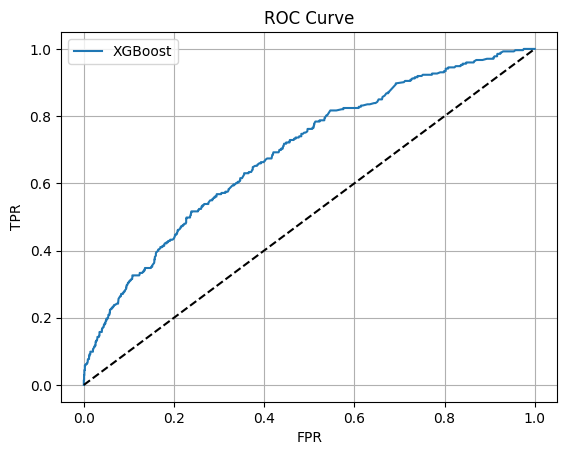

In [22]:
#  ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='XGBoost')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

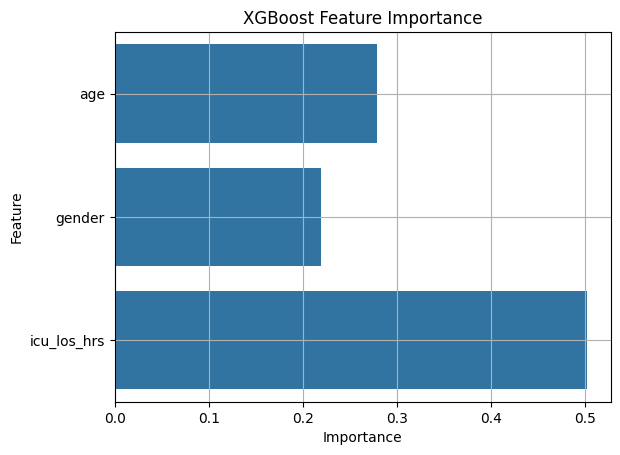

In [23]:
# Feature importance
import seaborn as sns

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})

sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('XGBoost Feature Importance')
plt.grid()
plt.show()

In [32]:
# 📝 Get discharge summaries and hospital_expire_flag
query = '''
SELECT ne.subject_id, ne.hadm_id, ne.text, a.hospital_expire_flag
FROM `physionet-data.mimiciii_notes.noteevents` AS ne
JOIN `physionet-data.mimiciii_clinical.admissions` AS a
ON ne.hadm_id = a.hadm_id
WHERE ne.category = 'Discharge summary'
AND ne.text IS NOT NULL
LIMIT 100
'''
df_notes = client.query(query).to_dataframe()
df_notes = df_notes.dropna(subset=['text'])
df_notes = df_notes.drop_duplicates('text')
df_notes.head()


,subject_id,hadm_id,text,hospital_expire_flag
0,57199,138831,Admission Date: [**2139-10-14**] ...,0
1,23669,103579,Admission Date: [**2178-5-15**] Dischar...,0
2,22800,151019,Admission Date: [**2195-1-5**] Discharge ...,0
3,21839,179441,Admission Date: [**2145-11-24**] Discha...,0
4,31501,161037,Admission Date: [**2119-9-16**] ...,0


In [33]:
# Use ClinicalBERT for note embedding
!pip install transformers --quiet
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

embeddings = np.array([get_bert_embedding(text) for text in df_notes['text'][:100]])

In [38]:
# Get discharge summaries and hospital_expire_flag
query = '''
SELECT ne.subject_id, ne.hadm_id, ne.text, a.hospital_expire_flag
FROM `physionet-data.mimiciii_notes.noteevents` AS ne
JOIN `physionet-data.mimiciii_clinical.admissions` AS a
ON ne.hadm_id = a.hadm_id
WHERE ne.category = 'Discharge summary'
AND ne.text IS NOT NULL
LIMIT 100
'''
df_notes = client.query(query).to_dataframe()
df_notes = df_notes.dropna(subset=['text'])
df_notes = df_notes.drop_duplicates('text')
df_notes.head()

,subject_id,hadm_id,text,hospital_expire_flag
0,57199,138831,Admission Date: [**2139-10-14**] ...,0
1,23669,103579,Admission Date: [**2178-5-15**] Dischar...,0
2,22800,151019,Admission Date: [**2195-1-5**] Discharge ...,0
3,21839,179441,Admission Date: [**2145-11-24**] Discha...,0
4,31501,161037,Admission Date: [**2119-9-16**] ...,0


In [39]:
# ✅ Use actual mortality labels
y_true = df_notes['hospital_expire_flag'][:100].values


In [42]:
# 🔁 Logistic regression on BERT embeddings (real labels)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(max_iter=500)
scores = cross_val_score(clf, embeddings, y_true, cv=3, scoring='roc_auc')
print("Mean AUC (3-fold CV):", np.mean(scores))

Mean AUC (3-fold CV): 0.7888888888888889
